In [26]:
# Cell 1: Import necessary libraries
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [27]:
# Cell 2: Define the dataset class
class CoronaryDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Get all jpg files and their corresponding labels from txt files
        self.samples = []
        for fname in os.listdir(image_dir):
            if fname.endswith(".jpg"):
                img_path = os.path.join(image_dir, fname)
                txt_path = os.path.join(image_dir, fname.replace(".jpg", ".txt"))
                # Check if the txt file exists
                if os.path.exists(txt_path):
                    try:
                        with open(txt_path, 'r') as f:
                            label = int(f.read().strip())
                        self.samples.append((img_path, label))
                    except (ValueError, FileNotFoundError):
                        print(f"Skipping {fname}: Issue with label file")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path  # Return path for identification

In [28]:
# Cell 3: Set up dataset and data loaders
# Set the correct dataset path
PROCESSED_DIR = "arterydir"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = CoronaryDataset(PROCESSED_DIR, transform=transform)
print(f"Total samples found: {len(dataset)}")

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Total samples found: 4238


In [29]:
# Cell 4: Set up the models
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize EfficientNet-B0 model
effnet_model = models.efficientnet_b0(pretrained=True)
effnet_model.classifier[1] = nn.Linear(effnet_model.classifier[1].in_features, 3)  # 3 classes
effnet_model.load_state_dict(torch.load("efficientnet_b0_artery_model.pth", map_location=device))
effnet_model = effnet_model.to(device)
effnet_model.eval()

# Initialize ResNet50 model
resnet_model = models.resnet50(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 3)  # 3 classes
resnet_model.load_state_dict(torch.load("resnet50_artery_model.pth", map_location=device))
resnet_model = resnet_model.to(device)
resnet_model.eval()

# Initialize VGG16 model
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 3)  # 3 classes
vgg_model.load_state_dict(torch.load("vgg16_artery_model.pth", map_location=device))
vgg_model = vgg_model.to(device)
vgg_model.eval()

Using device: cpu


c:\Users\paran\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\paran\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\paran\AppData\Local\Temp\ipykernel_19084\348854435.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code d

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
# Cell 5: Create Ensemble Class
class EnsembleModel:
    def __init__(self, models, weights=None):
        self.models = models
        # If weights are not provided, use equal weighting
        if weights is None:
            self.weights = [1/len(models)] * len(models)
        else:
            # Normalize weights to sum to 1
            total = sum(weights)
            self.weights = [w/total for w in weights]
    
    def predict(self, image_tensor):
        # Run inference with each model
        all_outputs = []
        for i, model in enumerate(self.models):
            output = model(image_tensor)
            # Apply softmax to get probabilities
            probabilities = torch.nn.functional.softmax(output, dim=1)
            # Apply weight to this model's output
            weighted_probs = probabilities * self.weights[i]
            all_outputs.append(weighted_probs)
        
        # Sum the weighted probabilities from all models
        ensemble_output = sum(all_outputs)
        
        # Get the predicted class (index of max probability)
        _, predicted = torch.max(ensemble_output, 1)
        return predicted, ensemble_output

In [31]:
# Cell 6: Evaluate each individual model first
def evaluate_model(model, data_loader, name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"{name} Accuracy: {accuracy:.2f}%")
    
    return all_preds, all_labels, accuracy

In [32]:
# Cell 7: Evaluate individual models
print("Evaluating individual models on validation set...")
_, _, effnet_acc = evaluate_model(effnet_model, 
                                DataLoader(val_data, batch_size=32, shuffle=False), 
                                "EfficientNet-B0")
_, _, resnet_acc = evaluate_model(resnet_model, 
                                DataLoader(val_data, batch_size=32, shuffle=False), 
                                "ResNet50")
_, _, vgg_acc = evaluate_model(vgg_model, 
                             DataLoader(val_data, batch_size=32, shuffle=False), 
                             "VGG16")

Evaluating individual models on validation set...
EfficientNet-B0 Accuracy: 98.70%
ResNet50 Accuracy: 98.00%
VGG16 Accuracy: 92.69%


In [33]:
# Cell 8: Create weighted ensemble based on model performances
# Use accuracy scores to determine weights
weights = [effnet_acc, resnet_acc, vgg_acc]
ensemble = EnsembleModel([effnet_model, resnet_model, vgg_model], weights=weights)

In [34]:
# Cell 9: Evaluate ensemble model
ensemble_preds = []
all_labels = []
ensemble_probs = []
total = 0
correct = 0

val_loader_with_paths = DataLoader(val_data, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels, paths in val_loader_with_paths:
        images, labels = images.to(device), labels.to(device)
        
        # Get ensemble predictions
        predicted, probs = ensemble.predict(images)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        ensemble_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        ensemble_probs.extend(probs.cpu().numpy())

ensemble_acc = 100 * correct / total
print(f"Ensemble Model Accuracy: {ensemble_acc:.2f}%")

Ensemble Model Accuracy: 99.17%


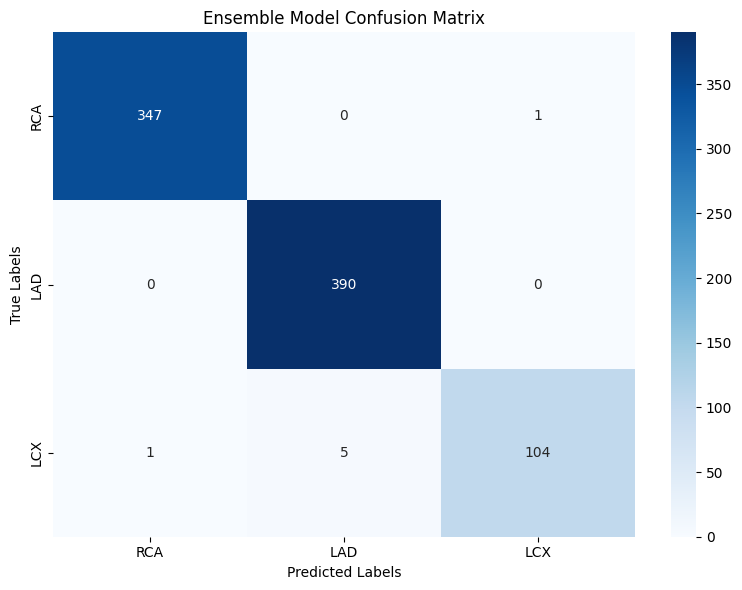

In [35]:
# Cell 10: Plot Confusion Matrix for Ensemble
class_names = ['RCA', 'LAD', 'LCX']
cm = confusion_matrix(all_labels, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Ensemble Model Confusion Matrix')
plt.tight_layout()
plt.savefig('ensemble_confusion_matrix.png')
plt.show()

In [36]:
# Cell 11: Display Classification Report for Ensemble
print("\nEnsemble Classification Report:")
report = classification_report(all_labels, ensemble_preds, target_names=class_names)
print(report)


Ensemble Classification Report:
              precision    recall  f1-score   support

         RCA       1.00      1.00      1.00       348
         LAD       0.99      1.00      0.99       390
         LCX       0.99      0.95      0.97       110

    accuracy                           0.99       848
   macro avg       0.99      0.98      0.99       848
weighted avg       0.99      0.99      0.99       848



In [37]:
# Cell 12: Fine-tune the ensemble
# Let's create a more sophisticated ensemble by training a meta-classifier
# We'll use the predictions from our base models as features

# Create a dataset for the meta-learner (stacking ensemble)
class MetaDataset(Dataset):
    def __init__(self, data_loader, models):
        self.models = models
        self.features = []
        self.labels = []
        
        # Generate features from base models
        with torch.no_grad():
            for images, labels, _ in data_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Collect predictions from each model
                model_outputs = []
                for model in models:
                    outputs = model(images)
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    model_outputs.append(probs)
                
                # Concatenate all model outputs for each sample
                batch_features = torch.cat(model_outputs, dim=1)  # Shape: [batch_size, 3*num_models]
                
                self.features.extend(batch_features.cpu().numpy())
                self.labels.extend(labels.cpu().numpy())
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), self.labels[idx]

In [38]:
# Cell 13: Create and train the meta-classifier
print("Creating meta-classifier dataset...")
meta_train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
meta_val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

meta_train_dataset = MetaDataset(meta_train_loader, [effnet_model, resnet_model, vgg_model])
meta_val_dataset = MetaDataset(meta_val_loader, [effnet_model, resnet_model, vgg_model])

meta_train_loader = DataLoader(meta_train_dataset, batch_size=32, shuffle=True)
meta_val_loader = DataLoader(meta_val_dataset, batch_size=32, shuffle=False)

# Define meta-classifier model
class MetaClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MetaClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize meta-classifier (input size is 3 classes * 3 models = 9)
meta_classifier = MetaClassifier(9, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(meta_classifier.parameters(), lr=0.001)

Creating meta-classifier dataset...


In [39]:
# Cell 14: Training and validation for meta-classifier
# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
print("Training meta-classifier...")
num_epochs = 50  # More epochs for meta-classifier since it's a smaller model

for epoch in range(num_epochs):
    # Training
    meta_classifier.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for features, labels in meta_train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = meta_classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = train_loss / len(meta_train_loader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation
    meta_classifier.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in meta_val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = meta_classifier(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(meta_val_loader)
    epoch_val_acc = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

# Save the meta-classifier
torch.save(meta_classifier.state_dict(), "meta_classifier_model.pth")
print("Meta-classifier saved to meta_classifier_model.pth")

Training meta-classifier...
Epoch 10/50, Train Loss: 0.0300, Train Acc: 99.29%, Val Loss: 0.0306, Val Acc: 99.17%
Epoch 20/50, Train Loss: 0.0275, Train Acc: 99.23%, Val Loss: 0.0321, Val Acc: 99.17%
Epoch 30/50, Train Loss: 0.0276, Train Acc: 99.32%, Val Loss: 0.0318, Val Acc: 99.17%
Epoch 40/50, Train Loss: 0.0266, Train Acc: 99.29%, Val Loss: 0.0329, Val Acc: 99.17%
Epoch 50/50, Train Loss: 0.0277, Train Acc: 99.35%, Val Loss: 0.0324, Val Acc: 99.17%
Meta-classifier saved to meta_classifier_model.pth


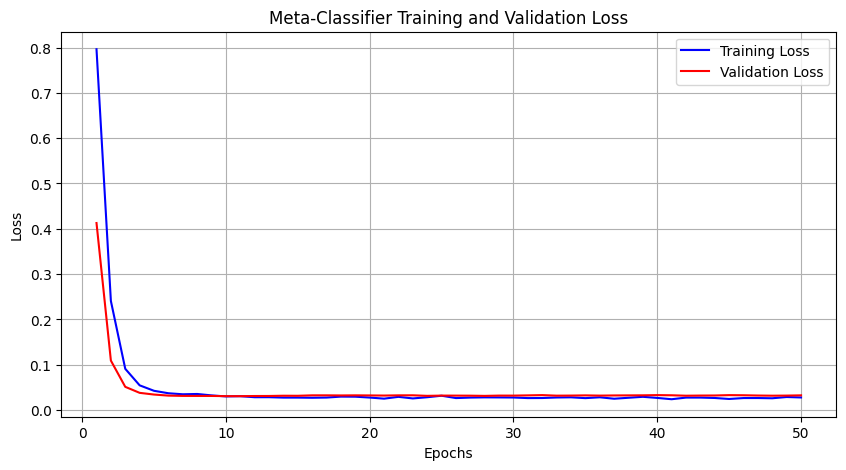

In [40]:
# Cell 15: Plot Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Meta-Classifier Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('ensemble_loss_graph.png')
plt.show()

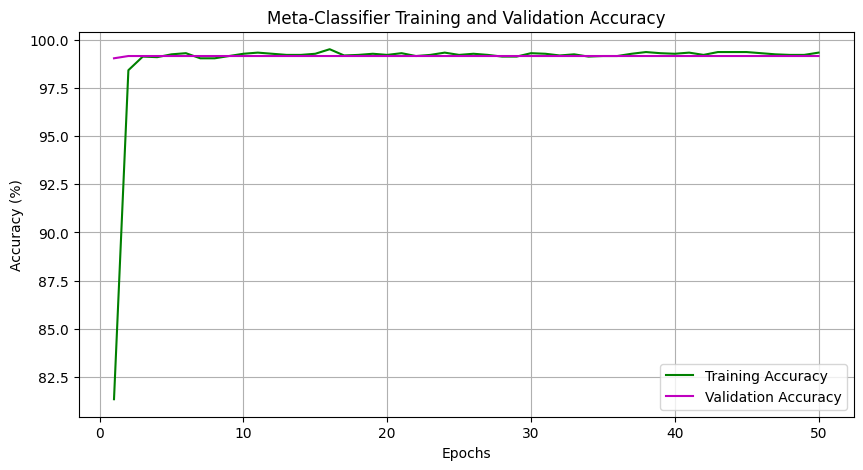

In [41]:
# Cell 16: Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'g-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'm-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Meta-Classifier Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('ensemble_accuracy_graph.png')
plt.show()

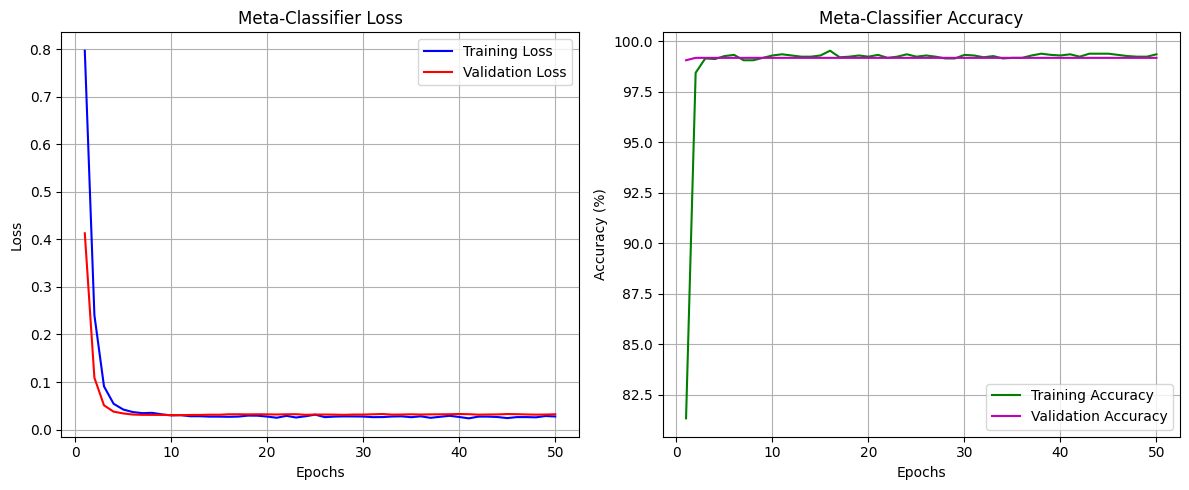

In [42]:
# Cell 17: Plot combined Train vs Validation Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Meta-Classifier Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'g-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'm-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Meta-Classifier Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ensemble_train_vs_val_graph.png')
plt.show()

In [43]:
# Cell 18: Evaluate stacked ensemble's final performance
# Generate predictions using the meta-classifier
meta_preds = []
all_true_labels = []

meta_classifier.eval()
with torch.no_grad():
    for features, labels in meta_val_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = meta_classifier(features)
        _, predicted = torch.max(outputs.data, 1)
        
        meta_preds.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

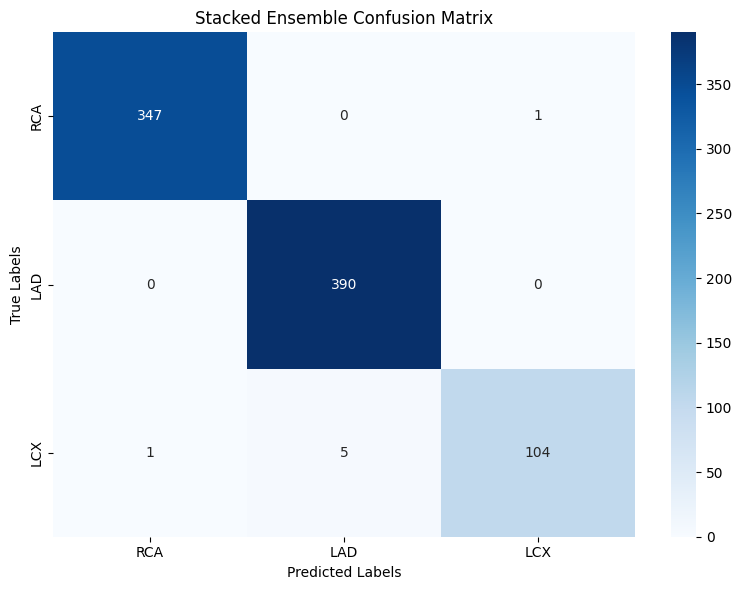

In [44]:
# Cell 19: Plot final stacked ensemble Confusion Matrix
cm = confusion_matrix(all_true_labels, meta_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Stacked Ensemble Confusion Matrix')
plt.tight_layout()
plt.savefig('stacked_ensemble_confusion_matrix.png')
plt.show()

In [45]:
# Cell 20: Display final Classification Report
stacked_acc = accuracy_score(all_true_labels, meta_preds) * 100
print(f"\nStacked Ensemble Accuracy: {stacked_acc:.2f}%")
print("\nStacked Ensemble Classification Report:")
report = classification_report(all_true_labels, meta_preds, target_names=class_names)
print(report)


Stacked Ensemble Accuracy: 99.17%

Stacked Ensemble Classification Report:
              precision    recall  f1-score   support

         RCA       1.00      1.00      1.00       348
         LAD       0.99      1.00      0.99       390
         LCX       0.99      0.95      0.97       110

    accuracy                           0.99       848
   macro avg       0.99      0.98      0.99       848
weighted avg       0.99      0.99      0.99       848



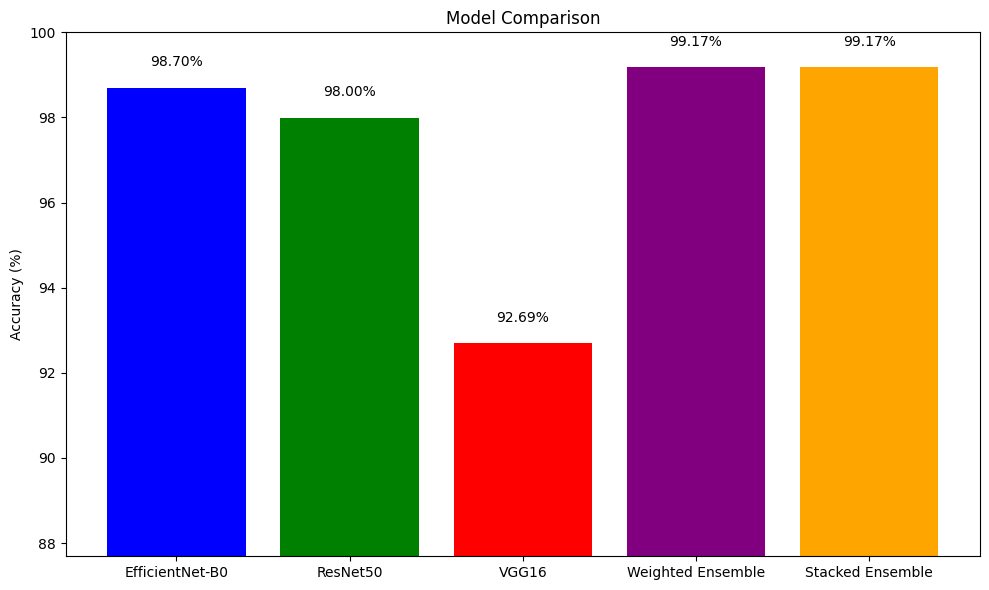

In [46]:
# Cell 21: Compare all models
model_names = ['EfficientNet-B0', 'ResNet50', 'VGG16', 'Weighted Ensemble', 'Stacked Ensemble']
accuracies = [effnet_acc, resnet_acc, vgg_acc, ensemble_acc, stacked_acc]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison')
plt.ylim(min(accuracies) - 5, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

In [47]:
# Cell 22: Define a comprehensive prediction function using the ensemble
def predict_artery_ensemble(img_path, base_models, meta_classifier, transform):
    # Load and preprocess the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not load image from {img_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    
    # Get predictions from base models
    model_outputs = []
    base_preds = []
    
    for model in base_models:
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            model_outputs.append(probs)
            _, pred = torch.max(output, 1)
            base_preds.append(pred.item())
    
    # Use the meta-classifier for final prediction
    meta_features = torch.cat(model_outputs, dim=1)
    
    meta_classifier.eval()
    with torch.no_grad():
        meta_output = meta_classifier(meta_features)
        _, meta_pred = torch.max(meta_output, 1)
    
    label_map = {0: "RCA", 1: "LAD", 2: "LCX"}
    base_model_names = ["EfficientNet-B0", "ResNet50", "VGG16"]
    ensemble_pred = label_map[meta_pred.item()]
    
    # Prepare results including individual model predictions
    results = {
        "ensemble_prediction": ensemble_pred,
        "individual_predictions": {
            model_name: label_map[pred] 
            for model_name, pred in zip(base_model_names, base_preds)
        }
    }
    
    return results

In [48]:
# Cell 23: Test the ensemble on a sample image
test_img_path = os.path.join(PROCESSED_DIR, "1_161.jpg")  # Update this to a specific image path that exists
if os.path.exists(test_img_path):
    results = predict_artery_ensemble(
        test_img_path, 
        [effnet_model, resnet_model, vgg_model], 
        meta_classifier, 
        transform
    )
    print(f"Ensemble Predicted Artery: {results['ensemble_prediction']}")
    print("Individual model predictions:")
    for model_name, pred in results['individual_predictions'].items():
        print(f"  - {model_name}: {pred}")
else:
    print(f"Test image not found at {test_img_path}")
    # Find first available image for testing
    sample_images = [f for f in os.listdir(PROCESSED_DIR) if f.endswith('.jpg')]
    if sample_images:
        test_img_path = os.path.join(PROCESSED_DIR, sample_images[0])
        print(f"Using alternative image: {test_img_path}")
        results = predict_artery_ensemble(
            test_img_path, 
            [effnet_model, resnet_model, vgg_model], 
            meta_classifier, 
            transform
        )
        print(f"Ensemble Predicted Artery: {results['ensemble_prediction']}")
        print("Individual model predictions:")
        for model_name, pred in results['individual_predictions'].items():
            print(f"  - {model_name}: {pred}")
    else:
        print("No jpg images found in the dataset directory.")

Ensemble Predicted Artery: RCA
Individual model predictions:
  - EfficientNet-B0: RCA
  - ResNet50: RCA
  - VGG16: RCA


Generating AUC-ROC curves for all models...


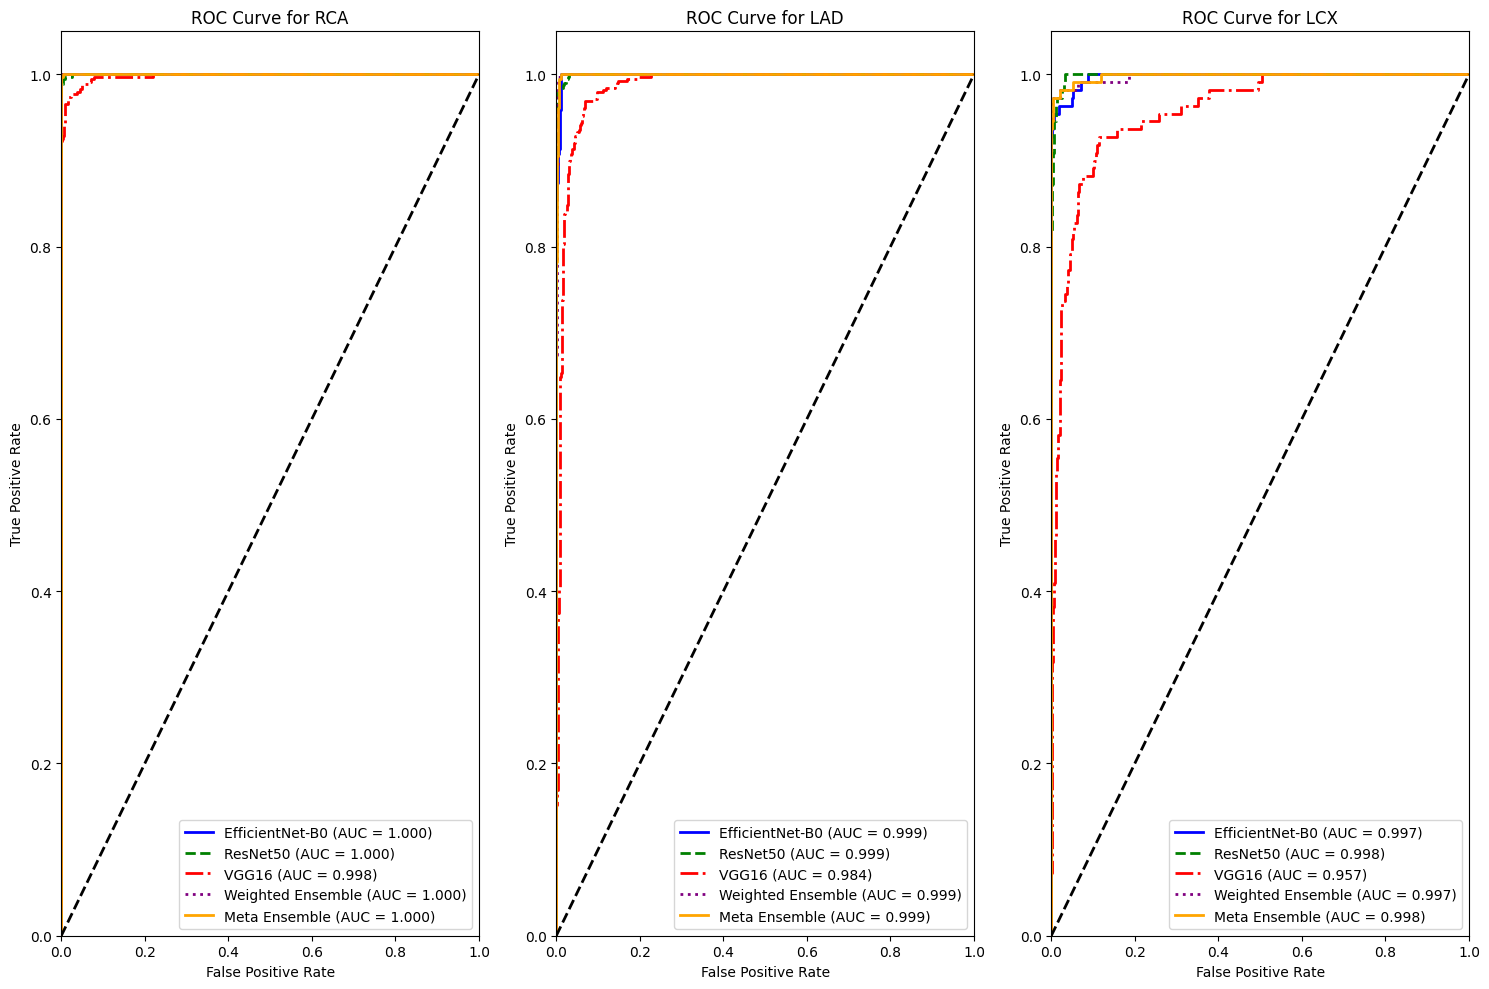


Overall Macro AUC scores:
EfficientNet-B0: 0.9988
ResNet50: 0.9992
VGG16: 0.9797
Weighted Ensemble: 0.9988
Meta Ensemble: 0.9991


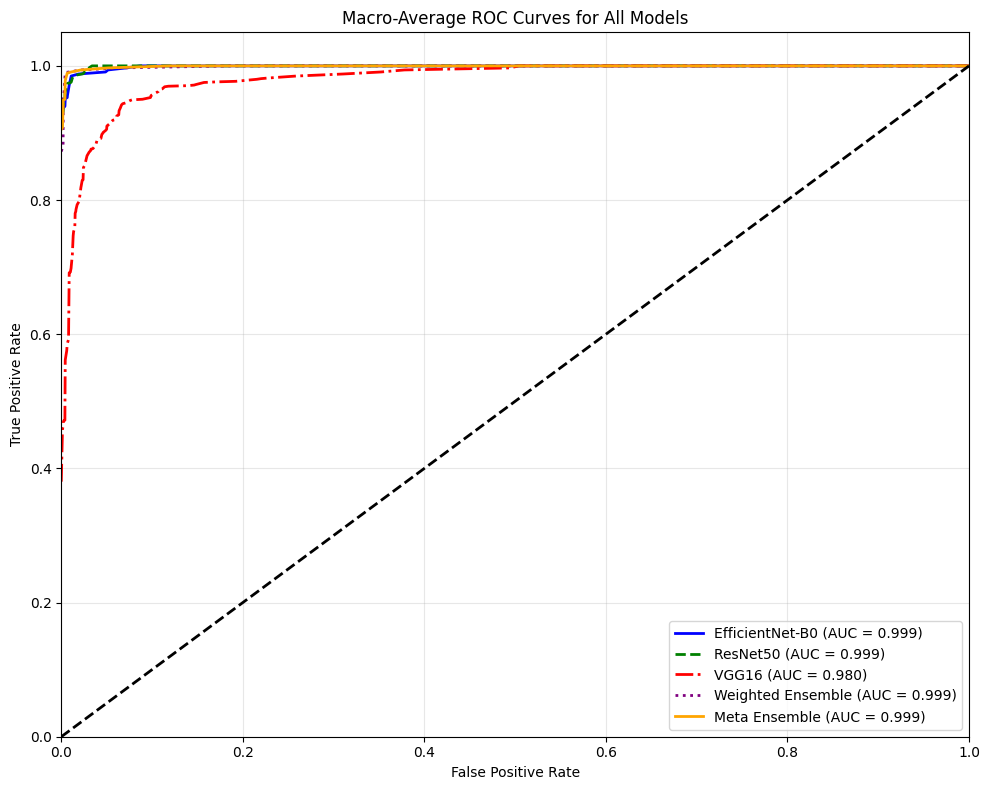

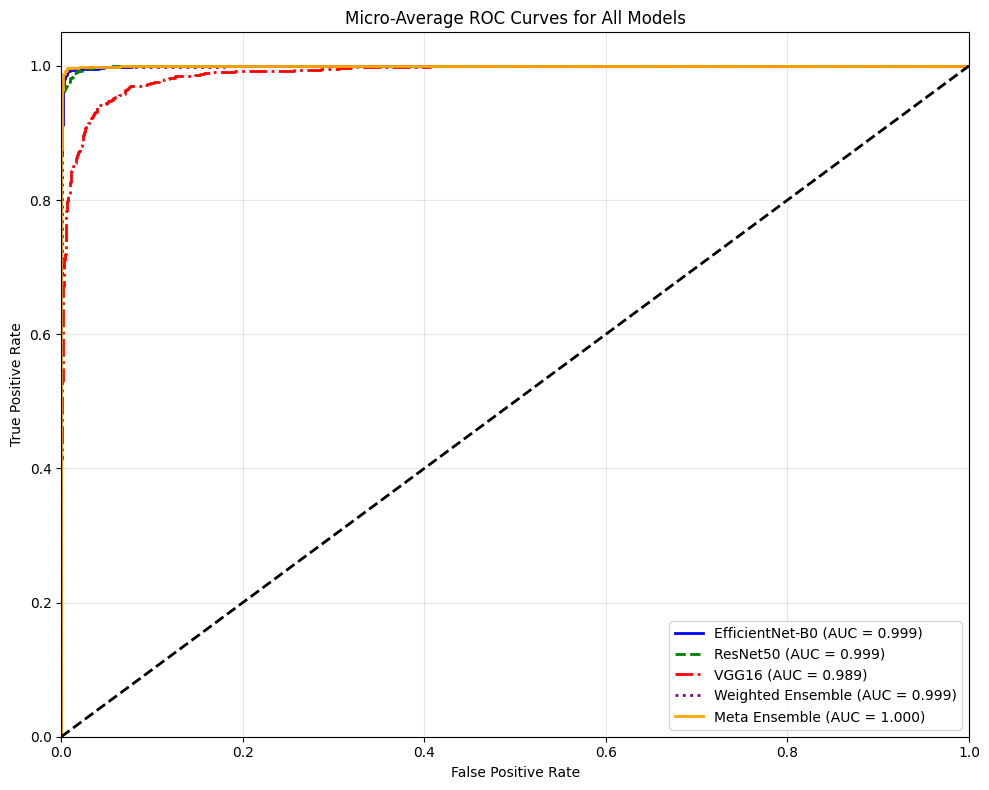


Summary of Model Performance:
Model                Accuracy   Macro AUC 
--------------------------------------------------
EfficientNet-B0      98.70%     0.9988
ResNet50             98.00%     0.9992
VGG16                92.69%     0.9797
Weighted Ensemble    99.17%     0.9988
Meta Ensemble        99.17%     0.9991


In [49]:
# Cell 24: Generate AUC-ROC curves
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# First, collect predictions and probabilities for all models
print("Generating AUC-ROC curves for all models...")

# Function to get predictions and probability scores
def get_predictions_and_probs(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            all_probs.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_probs), np.array(all_labels)

# Get predictions for each base model
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

effnet_probs, effnet_labels = get_predictions_and_probs(effnet_model, val_loader)
resnet_probs, resnet_labels = get_predictions_and_probs(resnet_model, val_loader)
vgg_probs, vgg_labels = get_predictions_and_probs(vgg_model, val_loader)

# Get ensemble probabilities
ensemble_probs = np.zeros_like(effnet_probs)
weights = [effnet_acc, resnet_acc, vgg_acc]
total_weight = sum(weights)
normalized_weights = [w/total_weight for w in weights]

ensemble_probs = (effnet_probs * normalized_weights[0] + 
                 resnet_probs * normalized_weights[1] + 
                 vgg_probs * normalized_weights[2])

# Get meta-classifier probabilities
meta_classifier.eval()
meta_probs = []
meta_true_labels = []

with torch.no_grad():
    for features, labels in meta_val_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = meta_classifier(features)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
        meta_probs.extend(probabilities.cpu().numpy())
        meta_true_labels.extend(labels.cpu().numpy())

meta_probs = np.array(meta_probs)
meta_true_labels = np.array(meta_true_labels)

# Binarize the labels for multi-class ROC
n_classes = 3
binarized_labels = label_binarize(effnet_labels, classes=[0, 1, 2])

# Calculate ROC curve and ROC area for each class and each model
fpr = dict()
tpr = dict()
roc_auc = dict()

# Dictionary to store models
models = {
    'EfficientNet-B0': effnet_probs,
    'ResNet50': resnet_probs,
    'VGG16': vgg_probs,
    'Weighted Ensemble': ensemble_probs,
    'Meta Ensemble': meta_probs
}

# Calculate ROC curves for each model
plt.figure(figsize=(15, 10))
colors = ['blue', 'green', 'red', 'purple', 'orange']
line_styles = ['-', '--', '-.', ':', '-']

# For each class
for i in range(n_classes):
    plt.subplot(1, 3, i+1)
    class_name = class_names[i]
    
    # For each model
    for (j, (model_name, probs)) in enumerate(models.items()):
        fpr_model, tpr_model, _ = roc_curve(binarized_labels[:, i], probs[:, i])
        roc_auc_model = auc(fpr_model, tpr_model)
        
        plt.plot(
            fpr_model, 
            tpr_model, 
            color=colors[j],
            linestyle=line_styles[j],
            lw=2, 
            label=f'{model_name} (AUC = {roc_auc_model:.3f})'
        )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {class_name}')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('auc_roc_curves.png', dpi=300)
plt.show()

# Calculate and display overall macro AUC scores for each model
print("\nOverall Macro AUC scores:")
for model_name, probs in models.items():
    # Calculate ROC AUC for each class
    roc_auc_scores = []
    for i in range(n_classes):
        fpr_model, tpr_model, _ = roc_curve(binarized_labels[:, i], probs[:, i])
        roc_auc_model = auc(fpr_model, tpr_model)
        roc_auc_scores.append(roc_auc_model)
    
    # Calculate macro average
    macro_auc = sum(roc_auc_scores) / len(roc_auc_scores)
    print(f"{model_name}: {macro_auc:.4f}")

# Create a single combined ROC curve for better visualization
# We'll plot the macro-average ROC curve for each model
plt.figure(figsize=(10, 8))

for (j, (model_name, probs)) in enumerate(models.items()):
    # Calculate ROC curve and ROC area for each class
    fpr_classes = dict()
    tpr_classes = dict()
    roc_auc_classes = dict()
    
    for i in range(n_classes):
        fpr_classes[i], tpr_classes[i], _ = roc_curve(binarized_labels[:, i], probs[:, i])
        roc_auc_classes[i] = auc(fpr_classes[i], tpr_classes[i])
    
    # Calculate macro-average ROC curve
    # First, interpolate all ROC curves to a common set of points
    all_fpr = np.unique(np.concatenate([fpr_classes[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_classes[i], tpr_classes[i])
    
    # Average and compute AUC
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    
    plt.plot(
        all_fpr, 
        mean_tpr, 
        color=colors[j],
        linestyle=line_styles[j],
        lw=2, 
        label=f'{model_name} (AUC = {macro_auc:.3f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('macro_average_roc_curves.png', dpi=300)
plt.show()

# Calculate micro-average ROC curve (treating all classes as one)
plt.figure(figsize=(10, 8))

for (j, (model_name, probs)) in enumerate(models.items()):
    # Reshape predictions and labels for micro-averaging
    y_score_flat = probs.ravel()
    y_true_flat = np.zeros_like(y_score_flat)
    
    # Set the true values
    for i in range(n_classes):
        class_indices = np.where(binarized_labels[:, i] == 1)[0]
        true_indices = class_indices * n_classes + i
        y_true_flat[true_indices] = 1
    
    # Calculate micro-average ROC curve and ROC area
    fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_score_flat)
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    plt.plot(
        fpr_micro, 
        tpr_micro, 
        color=colors[j],
        linestyle=line_styles[j],
        lw=2, 
        label=f'{model_name} (AUC = {roc_auc_micro:.3f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('micro_average_roc_curves.png', dpi=300)
plt.show()

# Finally, print a summary of the results
print("\nSummary of Model Performance:")
print("=" * 50)
print(f"{'Model':<20} {'Accuracy':<10} {'Macro AUC':<10}")
print("-" * 50)

for model_name, probs in models.items():
    # Get accuracy
    if model_name == 'EfficientNet-B0':
        acc = effnet_acc
    elif model_name == 'ResNet50':
        acc = resnet_acc
    elif model_name == 'VGG16':
        acc = vgg_acc
    elif model_name == 'Weighted Ensemble':
        acc = ensemble_acc
    else:  # Meta Ensemble
        acc = stacked_acc
    
    # Calculate macro AUC
    roc_auc_scores = []
    for i in range(n_classes):
        fpr_model, tpr_model, _ = roc_curve(binarized_labels[:, i], probs[:, i])
        roc_auc_model = auc(fpr_model, tpr_model)
        roc_auc_scores.append(roc_auc_model)
    
    macro_auc = sum(roc_auc_scores) / len(roc_auc_scores)
    print(f"{model_name:<20} {acc:.2f}%     {macro_auc:.4f}")

print("=" * 50)

In [51]:
# Cell 25: K-Fold Cross-Validation for Ensemble Models
from sklearn.model_selection import KFold
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print("Implementing K-Fold Cross-Validation...")

# Load the full dataset
full_dataset = CoronaryDataset(PROCESSED_DIR, transform=transform)
print(f"Total samples in dataset: {len(full_dataset)}")

# Parameters
k_folds = 5
num_epochs = 15  # Reduced for time efficiency
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For storing results
fold_accuracies = {
    'EfficientNet': [],
    'ResNet': [],
    'VGG': [],
    'Weighted Ensemble': [],
    'Meta Ensemble': []
}
fold_auc_scores = {
    'EfficientNet': [],
    'ResNet': [],
    'VGG': [],
    'Weighted Ensemble': [],
    'Meta Ensemble': []
}

# Define splits for K-Fold
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Keep track of best weights for each model
best_weights = {
    'EfficientNet': None,
    'ResNet': None, 
    'VGG': None,
    'Meta': None
}
best_performance = {
    'EfficientNet': 0,
    'ResNet': 0,
    'VGG': 0, 
    'Meta': 0
}

# Start k-fold cross validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(full_dataset)):
    print(f"\n----- FOLD {fold+1}/{k_folds} -----")
    
    # Sample data for this fold
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = DataLoader(
                      full_dataset, 
                      batch_size=batch_size, 
                      sampler=train_subsampler)
    test_loader = DataLoader(
                     full_dataset,
                     batch_size=batch_size,
                     sampler=test_subsampler)
    
    # Initialize models for this fold
    
    # EfficientNet model
    effnet = models.efficientnet_b0(pretrained=True)
    effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, 3)
    effnet = effnet.to(device)
    
    # ResNet model
    resnet = models.resnet50(pretrained=True)
    resnet.fc = nn.Linear(resnet.fc.in_features, 3)
    resnet = resnet.to(device)
    
    # VGG model
    vgg = models.vgg16(pretrained=True)
    vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 3)
    vgg = vgg.to(device)
    
    # Define optimizers
    effnet_optimizer = optim.Adam(effnet.parameters(), lr=0.0001)
    resnet_optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
    vgg_optimizer = optim.Adam(vgg.parameters(), lr=0.0001)
    
    criterion = nn.CrossEntropyLoss()
    
    # Lists to store metrics for current fold
    epoch_train_losses = {
        'EfficientNet': [], 'ResNet': [], 'VGG': []
    }
    epoch_test_losses = {
        'EfficientNet': [], 'ResNet': [], 'VGG': []
    }
    epoch_train_accs = {
        'EfficientNet': [], 'ResNet': [], 'VGG': []
    }
    epoch_test_accs = {
        'EfficientNet': [], 'ResNet': [], 'VGG': []
    }
    
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Set models to train mode
        effnet.train()
        resnet.train()
        vgg.train()
        
        # Training metrics for this epoch
        train_losses = {'EfficientNet': 0, 'ResNet': 0, 'VGG': 0}
        train_correct = {'EfficientNet': 0, 'ResNet': 0, 'VGG': 0}
        train_total = 0
        
        # Training
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            train_total += labels.size(0)
            
            # EfficientNet
            effnet_optimizer.zero_grad()
            effnet_outputs = effnet(images)
            effnet_loss = criterion(effnet_outputs, labels)
            effnet_loss.backward()
            effnet_optimizer.step()
            train_losses['EfficientNet'] += effnet_loss.item()
            _, effnet_predicted = torch.max(effnet_outputs.data, 1)
            train_correct['EfficientNet'] += (effnet_predicted == labels).sum().item()
            
            # ResNet
            resnet_optimizer.zero_grad()
            resnet_outputs = resnet(images)
            resnet_loss = criterion(resnet_outputs, labels)
            resnet_loss.backward()
            resnet_optimizer.step()
            train_losses['ResNet'] += resnet_loss.item()
            _, resnet_predicted = torch.max(resnet_outputs.data, 1)
            train_correct['ResNet'] += (resnet_predicted == labels).sum().item()
            
            # VGG
            vgg_optimizer.zero_grad()
            vgg_outputs = vgg(images)
            vgg_loss = criterion(vgg_outputs, labels)
            vgg_loss.backward()
            vgg_optimizer.step()
            train_losses['VGG'] += vgg_loss.item()
            _, vgg_predicted = torch.max(vgg_outputs.data, 1)
            train_correct['VGG'] += (vgg_predicted == labels).sum().item()
        
        # Calculate training metrics
        for model_name in ['EfficientNet', 'ResNet', 'VGG']:
            epoch_train_loss = train_losses[model_name] / len(train_loader)
            epoch_train_acc = train_correct[model_name] / train_total * 100
            epoch_train_losses[model_name].append(epoch_train_loss)
            epoch_train_accs[model_name].append(epoch_train_acc)
        
        # Validation
        effnet.eval()
        resnet.eval()
        vgg.eval()
        
        test_losses = {'EfficientNet': 0, 'ResNet': 0, 'VGG': 0}
        test_correct = {'EfficientNet': 0, 'ResNet': 0, 'VGG': 0}
        test_total = 0
        
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images, labels = images.to(device), labels.to(device)
                test_total += labels.size(0)
                
                # EfficientNet
                effnet_outputs = effnet(images)
                effnet_loss = criterion(effnet_outputs, labels)
                test_losses['EfficientNet'] += effnet_loss.item()
                _, effnet_predicted = torch.max(effnet_outputs.data, 1)
                test_correct['EfficientNet'] += (effnet_predicted == labels).sum().item()
                
                # ResNet
                resnet_outputs = resnet(images)
                resnet_loss = criterion(resnet_outputs, labels)
                test_losses['ResNet'] += resnet_loss.item()
                _, resnet_predicted = torch.max(resnet_outputs.data, 1)
                test_correct['ResNet'] += (resnet_predicted == labels).sum().item()
                
                # VGG
                vgg_outputs = vgg(images)
                vgg_loss = criterion(vgg_outputs, labels)
                test_losses['VGG'] += vgg_loss.item()
                _, vgg_predicted = torch.max(vgg_outputs.data, 1)
                test_correct['VGG'] += (vgg_predicted == labels).sum().item()
        
        # Calculate validation metrics
        for model_name in ['EfficientNet', 'ResNet', 'VGG']:
            epoch_test_loss = test_losses[model_name] / len(test_loader)
            epoch_test_acc = test_correct[model_name] / test_total * 100
            epoch_test_losses[model_name].append(epoch_test_loss)
            epoch_test_accs[model_name].append(epoch_test_acc)
            
            # Save best weights
            if epoch_test_acc > best_performance[model_name]:
                if model_name == 'EfficientNet':
                    best_weights[model_name] = effnet.state_dict().copy()
                elif model_name == 'ResNet':
                    best_weights[model_name] = resnet.state_dict().copy()
                elif model_name == 'VGG':
                    best_weights[model_name] = vgg.state_dict().copy()
                best_performance[model_name] = epoch_test_acc
        
        # Print status
        if (epoch + 1) % 5 == 0:
            epoch_time = time.time() - start_time
            print(f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s")
            for model_name in ['EfficientNet', 'ResNet', 'VGG']:
                print(f"  {model_name} - Train Loss: {epoch_train_losses[model_name][-1]:.4f}, "
                      f"Train Acc: {epoch_train_accs[model_name][-1]:.2f}%, "
                      f"Val Loss: {epoch_test_losses[model_name][-1]:.4f}, "
                      f"Val Acc: {epoch_test_accs[model_name][-1]:.2f}%")
    
    # Training complete for this fold. Now test the best models
    if best_weights['EfficientNet'] is not None:
        effnet.load_state_dict(best_weights['EfficientNet'])
    if best_weights['ResNet'] is not None:
        resnet.load_state_dict(best_weights['ResNet'])
    if best_weights['VGG'] is not None:
        vgg.load_state_dict(best_weights['VGG'])
    
    # Collect predictions and true labels for final evaluation
    all_preds = {
        'EfficientNet': [],
        'ResNet': [],
        'VGG': []
    }
    all_probs = {
        'EfficientNet': [],
        'ResNet': [],
        'VGG': []
    }
    all_true_labels = []
    
    # Get predictions from all models
    effnet.eval()
    resnet.eval()
    vgg.eval()
    
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            all_true_labels.extend(labels.cpu().numpy())
            
            # Get predictions from each model
            for model_name, model in [('EfficientNet', effnet), ('ResNet', resnet), ('VGG', vgg)]:
                outputs = model(images)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                
                all_preds[model_name].extend(preds.cpu().numpy())
                all_probs[model_name].extend(probs.cpu().numpy())
    
    # Convert lists to numpy arrays for easier processing
    for model_name in ['EfficientNet', 'ResNet', 'VGG']:
        all_preds[model_name] = np.array(all_preds[model_name])
        all_probs[model_name] = np.array(all_probs[model_name])
    all_true_labels = np.array(all_true_labels)
    
    # Create weighted ensemble predictions
    # Use validation accuracies as weights
    weights = [
        epoch_test_accs['EfficientNet'][-1],
        epoch_test_accs['ResNet'][-1],
        epoch_test_accs['VGG'][-1]
    ]
    total_weight = sum(weights)
    normalized_weights = [w/total_weight for w in weights]
    
    # Calculate weighted ensemble probabilities
    ensemble_probs = (
        all_probs['EfficientNet'] * normalized_weights[0] +
        all_probs['ResNet'] * normalized_weights[1] +
        all_probs['VGG'] * normalized_weights[2]
    )
    ensemble_preds = np.argmax(ensemble_probs, axis=1)
    
    # Now train a meta-classifier on these predictions
    # Create features by combining outputs from all models
    meta_features = np.concatenate([
        all_probs['EfficientNet'],
        all_probs['ResNet'],
        all_probs['VGG']
    ], axis=1)
    
    # Define and train meta-classifier
    meta_model = MetaClassifier(9, 3).to(device)
    meta_optimizer = optim.Adam(meta_model.parameters(), lr=0.001)
    
    # Use 80% of test data to train meta-model, 20% to validate
    meta_data_size = len(all_true_labels)
    meta_train_size = int(0.8 * meta_data_size)
    
    # Create indices for random split
    indices = np.random.permutation(meta_data_size)
    meta_train_indices = indices[:meta_train_size]
    meta_val_indices = indices[meta_train_size:]
    
    # Training data for meta-model
    meta_train_features = torch.tensor(meta_features[meta_train_indices], dtype=torch.float).to(device)
    meta_train_labels = torch.tensor(all_true_labels[meta_train_indices], dtype=torch.long).to(device)
    
    # Validation data for meta-model
    meta_val_features = torch.tensor(meta_features[meta_val_indices], dtype=torch.float).to(device)
    meta_val_labels = torch.tensor(all_true_labels[meta_val_indices], dtype=torch.long).to(device)
    
    # Train meta-model
    for epoch in range(30):  # Fewer epochs for meta-model
        meta_model.train()
        meta_optimizer.zero_grad()
        outputs = meta_model(meta_train_features)
        loss = criterion(outputs, meta_train_labels)
        loss.backward()
        meta_optimizer.step()
    
    # Evaluate meta-model
    meta_model.eval()
    with torch.no_grad():
        meta_outputs = meta_model(meta_val_features)
        meta_probs = torch.nn.functional.softmax(meta_outputs, dim=1)
        _, meta_preds = torch.max(meta_outputs, 1)
    
    # Calculate final metrics for this fold
    def calculate_metrics(model_name, predictions, probs, true_labels):
        # Calculate accuracy
        acc = accuracy_score(true_labels, predictions) * 100
        fold_accuracies[model_name].append(acc)
        
        # Calculate AUC (one vs rest)
        # Binarize the labels for multi-class ROC
        binarized_labels = label_binarize(true_labels, classes=[0, 1, 2])
        
        # Calculate ROC AUC for each class
        roc_auc_scores = []
        for i in range(3):  # 3 classes
            roc_auc_scores.append(roc_auc_score(binarized_labels[:, i], probs[:, i]))
        
        # Calculate macro average
        macro_auc = sum(roc_auc_scores) / len(roc_auc_scores)
        fold_auc_scores[model_name].append(macro_auc)
        
        return acc, macro_auc
    
    # Calculate metrics for all models
    print(f"\nFold {fold+1} Results:")
    print("-" * 50)
    print(f"{'Model':<20} {'Accuracy':<10} {'Macro AUC':<10}")
    print("-" * 50)
    
    # Base models
    for model_name in ['EfficientNet', 'ResNet', 'VGG']:
        acc, auc = calculate_metrics(
            model_name, 
            all_preds[model_name], 
            all_probs[model_name], 
            all_true_labels
        )
        print(f"{model_name:<20} {acc:.2f}%     {auc:.4f}")
    
    # Weighted ensemble
    acc, auc = calculate_metrics(
        'Weighted Ensemble',
        ensemble_preds,
        ensemble_probs,
        all_true_labels
    )
    print(f"{'Weighted Ensemble':<20} {acc:.2f}%     {auc:.4f}")
    
    # Meta ensemble
    meta_preds_np = meta_preds.cpu().numpy()
    meta_probs_np = meta_probs.cpu().numpy()
    meta_labels_np = meta_val_labels.cpu().numpy()
    
    acc, auc = calculate_metrics(
        'Meta Ensemble',
        meta_preds_np,
        meta_probs_np,
        meta_labels_np
    )
    print(f"{'Meta Ensemble':<20} {acc:.2f}%     {auc:.4f}")
    print("-" * 50)
    
    # Reset best performance for next fold
    best_performance = {
        'EfficientNet': 0,
        'ResNet': 0,
        'VGG': 0, 
        'Meta': 0
    }

# Calculate and print average results across all folds
print("\n============ K-FOLD CROSS-VALIDATION RESULTS ============")
print(f"{'Model':<20} {'Avg Accuracy':<15} {'Std Dev':<10} {'Avg AUC':<10} {'Std Dev':<10}")
print("-" * 70)

for model_name in fold_accuracies.keys():
    avg_acc = np.mean(fold_accuracies[model_name])
    std_acc = np.std(fold_accuracies[model_name])
    avg_auc = np.mean(fold_auc_scores[model_name])
    std_auc = np.std(fold_auc_scores[model_name])
    
    print(f"{model_name:<20} {avg_acc:.2f}%        {std_acc:.2f}%      {avg_auc:.4f}    {std_auc:.4f}")

print("-" * 70)

# Plot the distribution of accuracies across folds
plt.figure(figsize=(12, 8))
model_names = list(fold_accuracies.keys())
data = [fold_accuracies[model] for model in model_names]

plt.boxplot(data, labels=model_names)
plt.title('Model Accuracy Distribution Across K-Folds')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('kfold_accuracy_distribution.png')
plt.show()

# Plot the distribution of AUC scores across folds
plt.figure(figsize=(12, 8))
data_auc = [fold_auc_scores[model] for model in model_names]

plt.boxplot(data_auc, labels=model_names)
plt.title('Model AUC Score Distribution Across K-Folds')
plt.ylabel('AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('kfold_auc_distribution.png')
plt.show()

# Summarize the fold variations using a bar chart with error bars
plt.figure(figsize=(12, 8))
x = np.arange(len(model_names))
width = 0.35

# Calculate means and standard deviations
acc_means = [np.mean(fold_accuracies[m]) for m in model_names]
acc_stds = [np.std(fold_accuracies[m]) for m in model_names]
auc_means = [np.mean(fold_auc_scores[m]) for m in model_names]
auc_stds = [np.std(fold_auc_scores[m]) for m in model_names]

# Create bar chart
fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.bar(x - width/2, acc_means, width, label='Accuracy', yerr=acc_stds, 
        color='skyblue', capsize=5)
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim([min(acc_means) - max(acc_stds) - 5, 100])

ax2 = ax1.twinx()
ax2.bar(x + width/2, auc_means, width, label='AUC', yerr=auc_stds,
        color='lightgreen', capsize=5)
ax2.set_ylabel('AUC Score')
ax2.set_ylim([min(auc_means) - max(auc_stds) - 0.05, 1.05])

ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.set_title('Model Performance Across K-Folds (Mean ± Std Dev)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('kfold_performance_summary.png')
plt.show()

Implementing K-Fold Cross-Validation...
Total samples in dataset: 4238

----- FOLD 1/5 -----


AttributeError: 'dict' object has no attribute 'efficientnet_b0'